In [1]:
# Importation des librairies et des fonctions pour le pre-traitement des données du corpus

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import string
import glob


# Imprtation librairie "time" pour le calcul du temps d'exécution des modèles

import time


# Importation des libraires pour vectorisation des données, pour la construction de la Pipeline des modèles et
# pour la visualisation de l'évaluation des performances des modèles.
# Les modèles importés sont : Naive-Bayes (BernoulliNB car le problème est à deux classes) et SVM (SupportVectorClassifier)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline


In [2]:
# Téléchargement du paquet "averaged_perceptron_tagger" nécessaire à l'étiquetage en POS des tokens

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/diego/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Importation du contenu écrit des commentaires négatifs dans une liste "neg"

neg = []

for neg_txt in glob.glob("../Corpus/neg/*.txt"):
    with open(neg_txt) as f:
        neg.append(f.read())

In [4]:
# Importation du contenu écrit des commentaires positifs dans une liste "pos"


pos = []

for pos_txt in glob.glob("../Corpus/pos/*.txt"):
    with open(pos_txt) as f:
        pos.append(f.read())

In [5]:
# Création d'une DataFrame pour les commentaires négatifs

df_neg = pd.DataFrame({"texte":neg,"label":"negative"},index=[x for x in range(1000)])

In [6]:
# Création d'une DataFrame pour les commentaires positifs

df_pos = pd.DataFrame({"texte":pos,"label":"positive"},index=[x for x in range(1000,2000)])

In [7]:
# Création d'une DataFrame unique grace à la fusion des deux précédentes. La DataFrame contient deux attributs:
# 1) Attribut "texte" dont la valeur est un commentaire
# 2) Attribut "label" dont la valeur est "negative" ou "positive"

frames = [df_neg,df_pos]

df = pd.concat(frames)


# On va mélanger les lignes de notre DataFrame pour ne pas avoir que les commentaires négatifs dans la première moitié
# et que les commentaires positifs dans la deuxième moitié

df = df.sample(frac=1,random_state=1).reset_index()
df = df.drop(columns=["index"])

In [8]:
# Aperçu da la DataFrame obtenue

df.head()

texte     label
0  susan granger's review of " jeepers creepers "...  negative
1   " a bug's life " may not be " toy story , " b...  positive
2  pollock starring ed harris , marcia gay harden...  positive
3  i recall the trials and tribulations of my hig...  positive
4  bob the happy bastard's quickie review : \nrus...  positive

In [9]:
# Division en X = Commentaires et y = labels

X = df["texte"]
y = df["label"]

In [10]:
# Pre-traitement des données (pour chaque commentaire):

# 1) Tokenisation et étiquetage en POS
# 2) Lemmatisation des tokens
# 3) Effacement des signes de ponctuation
# 4) Effacement des stop-words pour la langue anglaise
# 5) Unification des tokens lemmatisés restants et remplacement ligne par ligne de la liste X = Commentaires

lemmatizer = WordNetLemmatizer()


for index,line in enumerate(X):
    new_line = []
    for word, tag in pos_tag(word_tokenize(line)):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        if not wntag:
            lemma = word
            new_line.append(lemma)
        else:
            lemma = lemmatizer.lemmatize(word, wntag)
            new_line.append(lemma)
    string.punctuation = string.punctuation + "``" + "\'"
    new_line = list(filter(lambda token : token not in string.punctuation, new_line))
    new_line = list(filter(lambda token : token not in stopwords.words("english"), new_line))
    cleaned_line = []
    for word in new_line:
        if word == "\'re":
            word = "be"
            cleaned_line.append(word)
        else:
            cleaned_line.append(word)
    cleaned_line = " ".join(cleaned_line)
    X = X.replace([line],cleaned_line)

In [11]:
# Aperçu d'un commentaire nettoyé de X = Commentaires

X[8]

"star war episode phantom menace review review jamey hughton star starring-liam neeson ewan mcgregor natalie portman jake lloyd director-george lucas rat g hype star war episode 1- phantom menace receive seem almost impossible avoid interest see film movie easily anticipated motion picture ever marketing campaign strong bring colonel sander taco bell chihuahua pizza hut together george lucas succeed yet transport us back long time ago galaxy far far away yes star war prequel may worst bunch amateurish dialogue overall lack humanity n't mean fail comply basis solid entertainment phantom menace feature eye-catching jaw-dropping visual look cinematic history tremendous action sequence cling arm rest special effect nothing short best plentiful ever catch film vast digitized world sheer imagination apply project astound phantom menace delectable feast sens even disappointing aspect be treat famous prologue sky john williams thunder score meet qui-gon jonn liam neeson young obi-wan kenobi ew

In [25]:
# Division des données pré-traitées pour l'entrainement du modèle et pour le test sur des données que le modèle
# entrainé n'a pas encore traité. Le modèle sera entrainé sur le 70% des donnés (la taille des données à tester 
# est donc 30% du corpus).

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [26]:
# Choix de l'utilisateur entre le modèle SVM (SVC) ou Naaive-Bayes (BernoulliNB)

model_selection = input("Choisir le modèle : taper SVC ou NB ")

while True:
    if model_selection == "SVC":
        break
    elif model_selection == "NB":
        break
    else:
        model_selection = input("Taper SVC ou NB ")

chosen_model = None
if model_selection == "SVC":
    chosen_model = SVC(probability=True, kernel="linear")
elif model_selection == "NB":
    chosen_model = BernoulliNB()

Choisir le modèle : taper SVC ou NB SVC


In [27]:
# Création de la Pipeline du modèle:
# 1) Vectorisatin avec la méthode TextFrequencyInverseDocumentFrequency
# 2) Application du classifieur choisi par l'utilisateur

text_clf = Pipeline([("tfidf", TfidfVectorizer()),("clf", chosen_model)])

In [28]:
# On passe à l'entrainement supervisé du modèle en lui donnant nos X = Commentaires y = labels

st = time.time()

text_clf.fit(X_train, y_train)


# Calcul du temps d'entrainement du modèle choisi

et = time.time()
elapsed_time = et - st
print(f'Temps d\'entrainement du modèle {model_selection}: {elapsed_time} secondes')

Temps d'entrainement du modèle SVC: 29.33668279647827 secondes


In [29]:
# Une fois le modèle entrainé, on lui fait prédire les "labels" des données présents dans X_test ainsi que
# les percentages de probabilité pour chaque classe.

predictions = text_clf.predict(X_test)
predictions_proba = text_clf.predict_proba(X_test)

In [31]:
# Pour visualiser les resultats et évaluer notre modèle, on va créer une liste de tuple conténant:
# 1) Les commentaires présents dans X_test
# 2) Les labels prédits par nos modèles

visu = list(zip(X_test, predictions))
visu = [list(tup) for tup in visu]

print(visu[0])

["fugitive probably one greatest thriller ever make take realistic believable character tell exciting story 's totally believable throughout n't over-the-top action flick sake action intelligent adventure story real sense mystery work perfectly harrison ford star dr richard kimble man wrongly accuse convict murder wife entire premise story revolve around murder tell straightforward manner constantly see flashback murder kimble 's perspective hint drop various time night kimble 's wife helen sela ward murder n't get see killer much far story fact might even little doubt kimble 's innocence film n't spend much time detail kimble 's trial conviction point story one greatest action scene ensues get botch escape attempt fellow inmate lead fantastic train wreck seem gratuitous formulate actually suspenseful watch movie incredible 's able take element like make wholly original believable tommy lee jones almost steal show deputy sam gerard u marshall expert hunt fugitive moment appear know hug

In [35]:
visu_proba = list(zip(X_test, predictions_proba))
visu_proba = [list(tup) for tup in visu_proba]

print(visu[0])

["fugitive probably one greatest thriller ever make take realistic believable character tell exciting story 's totally believable throughout n't over-the-top action flick sake action intelligent adventure story real sense mystery work perfectly harrison ford star dr richard kimble man wrongly accuse convict murder wife entire premise story revolve around murder tell straightforward manner constantly see flashback murder kimble 's perspective hint drop various time night kimble 's wife helen sela ward murder n't get see killer much far story fact might even little doubt kimble 's innocence film n't spend much time detail kimble 's trial conviction point story one greatest action scene ensues get botch escape attempt fellow inmate lead fantastic train wreck seem gratuitous formulate actually suspenseful watch movie incredible 's able take element like make wholly original believable tommy lee jones almost steal show deputy sam gerard u marshall expert hunt fugitive moment appear know hug

In [32]:
# Finalement, on va visualiser les évaluations des performances du modèle choisi...

predictions = list(predictions)
y_test = list(y_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    negative       0.87      0.83      0.85       198
    positive       0.84      0.88      0.86       202

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



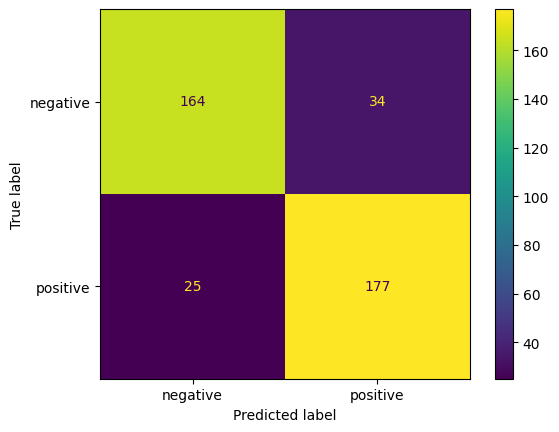

In [33]:
# ... et la matrice de confusion

labels = ["negative", "positive"]
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();